## GEO 877 - Spatial Algorithms 
### Group Kirsteina 
#### Tamara, Joya, Andrejs, Djordje

### Data


#### Description
For our analysis, we will be using the following data:
- Park data - Grünfläschen - Stadt Zürich - **BOUNDARY DATA**
    - 4 data types: Parks, Sports Areas, Cemeteries, Other
    - We will use Parks, Sports Areas, and Cemeteries as designated "parks"
    - We are considering adding Forests to the "parks" set
        - Could someone please download it, I can't: https://www.stadt-zuerich.ch/geodaten/download/111
    - **Can we find a shapefile somewhere that has just green areas as polygons?** we can use it to calculate % areas - OSM?


- Fountain data - **EVALUATION DATA**
    - Brunnen - fountains for heat relief
    - Stillgewässer - fountains for drinking 
    - **Can we find a shapefile somewhere that has just water areas as polygons?** we can use it to calculate % areas - OSM


- ZüriWC data - **EVALUATION DATA**
    - Location of publicly accessible WCs


- Spielpark data - **EVALUATION DATA**
    - Location of kids' playgrounds


- LIDAR data - Canopy Height - **EVALUATION DATA**
    - Download link: https://www.stadt-zuerich.ch/geodaten/download/Baumhoehen_2022__CHM_aus_Lidar_ 


- Socialshilfe data - **EVALUATION DATA**
    - Data on Social Assistance Quotas - need additional clarity whether this is percent of residents that receive Social Assistance or else


#### Data Structure

| PolygonID | Polygon Info | Green Area | Water Area | WC | Fountain | Playground | Socialshilfe | Canopy Height |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| X1 | coordinates | % of park | % of park | yes/no boolean | yes/no boolean | yes/no boolean | quota* | height* |

*needs more thought and discussion


### Analysis Workflow - Preliminary


1. Create park polygons:
    1. Download Wald data
    2. Remove "other" category
    3. Add Wald data
    4. Finalize all polygons - ensure all lines are cohesive
2. LIDAR Data:
    1. Prepare LIDAR data
    2. Extract only relevant data for Parks (Union of Park extent and LIDAR) to remove excess
3. Calculations:
    1. Park area as green space - %
    2. Park area as water space - %
4. Data Merge:
    1. Green area - join data to each park
    2. Water area - join data to each park
    3. Socialshilfe - join data to each park
5. Point in Polygon:
    1. WC - each park receives a numeric value
    2. Fountain - each park receives a numeric value
    3. Playground - each park receives a numeric value
6. Point in Polygon - translated:
    1. For each (WC, Fountain, Playground) assign a yes/no as result of a logical test loop (0 = no, 0> yes)
7. LIDAR Data
    1. **Determine a way to use this data** that is in line with the paper
8. Clustering


### Production

In [3]:
#Packages

from geospatial import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.geometry import shape
from shapely.ops import unary_union


#### 0. Spatial algorithms

In [1]:
#ALGORITHMS 

from numpy import sqrt, radians, arcsin, sin, cos

####### Point #######

class Point():
    # initialise
    def __init__(self, x=None, y=None):
        self.x = x
        self.y = y
    
    # representation
    def __repr__(self):
        return f'Point(x={self.x:.2f}, y={self.y:.2f})'

        # Test for equality between Points
    def __eq__(self, other): 
        if not isinstance(other, Point):
            # don't attempt to compare against unrelated types
            return NotImplemented
        return self.x == other.x and self.y == other.y

    # We need this method so that the class will behave sensibly in sets and dictionaries
    def __hash__(self):
        return hash((self.x, self.y))
    
    # calculate Euclidean distance between two points
    def distEuclidean(self, other):
        return sqrt((self.x-other.x)**2 + (self.y-other.y)**2)
    
    # calculate Manhattan distance between two points
    def distManhattan(self, other):
        return abs(self.x-other.x) + abs(self.y-other.y)

    # Haversine distance between two points on a sphere - requires lat/lng converted to radians
    def distHaversine(self, other):
        r = 6371000  # Earth's radius in metres (will return result in metres)
        phi1 = radians(self.y) # latitudes
        phi2 = radians(other.y)
        lam1 = radians(self.x) # longitudes
        lam2 = radians(other.x)

        d = 2 * r * arcsin(sqrt(sin((phi2 - phi1)/2)**2 + 
                                      cos(phi1) * cos(phi2) * sin((lam2 - lam1)/2)**2))
        return d   

    
    # Calculate determinant with respect to three points. Note the order matters here - we use it to work out left/ right in the next method
    def __det(self, p1, p2):
        det = (self.x-p1.x)*(p2.y-p1.y)-(p2.x-p1.x)*(self.y-p1.y)       
        return det

    def leftRight(self, p1, p2):
        # based on GIS Algorithms, Ch2, p11-12, by Ningchuan Xiao, publ. 2016
        # -ve: this point is on the left side of a line connecting p1 and p2
        #   0: this point is collinear
        # +ve: this point is on the right side of the line
        side = int(self.__det(p1, p2))
        if side != 0:
            side = side/abs(side)  # will return 0 if collinear, -1 for left, 1 for right
        return side
    
####### PointGroup #######
class PointGroup(): 
    # initialise
    def __init__(self, data=None, xcol=None, ycol=None):
        self.points = []
        self.size = len(data)
        for d in data:
            self.points.append(Point(d[xcol], d[ycol]))
    
    # representation
    def __repr__(self):
        return f'PointGroup containing {self.size} points' 
 
    # create index of points in group for referencing
    def __getitem__(self, key):
        return self.points[key]
    

####### Polygon #######
class Polygon(PointGroup):  
    # initialise
    def __init__(self, data=None, xcol=None, ycol=None):
        self.points = []
        self.size = len(data)
        for d in data:
            self.points.append(Point(d[xcol], d[ycol]))
        self.bbox = Bbox(self)
        
    # representation
    def __repr__(self):
        return f'Polygon PointGroup containing {self.size} points' 
  
    # test if polygon is closed: first and last point should be identical
    def isClosed(self):
        start = self.points[0]
        end = self.points[-1]
        return start == end

    def removeDuplicates(self):
        oldn = len(self.points)
        self.points = list(dict.fromkeys(self.points)) # Get rid of the duplicates
        self.points.append(self.points[0]) # Our polygon must have one duplicate - we put it back now
        n = len(self.points)
        print(f'The old polygon had {oldn} points, now we only have {n}.')
        
        # find area and centre of the polygon
    # - based on GIS Algorithms, Ch.2 p9-10, by Ningchuan Xiao, publ. 2016 
    
    def __signedArea(self):  # used for both area and centre calculations - this is a private method (only used within the class)
        a = 0
        xmean = 0
        ymean = 0
        for i in range(0, self.size-1):
            ai = self[i].x * self[i+1].y - self[i+1].x * self[i].y
            a += ai
            xmean += (self[i+1].x + self[i].x) * ai
            ymean += (self[i+1].y + self[i].y) * ai

        a = a/2.0   # signed area of polygon (can be a negative)
    
        return a, xmean, ymean
    
    def area(self):
        a, xmean, ymean = self.__signedArea()
        area = abs(a)   # absolute area of polygon
        
        return area

    def centre(self):
        a, xmean, ymean = self.__signedArea() # note we use the signed area here
        centre = Point(xmean/(6*a), ymean/(6*a)) # centre of polygon 
        return centre

    def containsPoint(self, p):
        if (self.bbox.containsPoint(p) == False):
            return False
        
        # Solution, as discussed in lecture, added here
        ray = Segment(p, Point(self.bbox.ur.x+1, p.y))
        count = 0
        
        for i in range(0, self.size-1):
            start = self[i]
            end = self[i+1]
            if (start.y != end.y): 
                if ((p.x < start.x) and (p.y == start.y)): 
                    count = count + 1
                else:
                    s = Segment(start, end)
                    if s.intersects(ray):
                        count = count + 1
              
        if (count%2 == 0):
            return False           

        return True

#### 1. Polygon creation

In [4]:
#Data Import

parks = gpd.read_file('data/grunflaschen_csv/data/gsz.gruenflaechen.csv')
#parks['produkt'].unique()

In [5]:
#Data Cleaning

#filter out "640 Weitere Freiräume"
filtered_park = []
for x, y in parks.iterrows():
    if y['produkt'] != "640 Weitere Freiräume":
        filtered_park.append(y)

dfParks = pd.DataFrame(filtered_park)

#dfParks['produkt'].unique()
#parks.info()

In [ ]:
#Coordinate conversion (POLYGON to list of tuples)

def parse_wkt_to_points(wkt_string):
    geometry = wkt.loads(wkt_string)  #using wkt from Shapely to handle the Polygon information (ChatGPT assistance)
    if isinstance(geometry, Polygon):
        return [(coord[0], coord[1]) for coord in geometry.exterior.coords] #extract coordinates
    
    elif isinstance(geometry, MultiPolygon): #edge case: multipolygons
        all_polygons = []
        for polygon in geometry.geoms:
            all_polygons.extend([(coord[0], coord[1]) for coord in polygon.exterior.coords]) #exterior coordinates for all polygons
        return all_polygons

    else:
        raise ValueError(f"Unsupported geometry type: {type(geometry)}") #unexpected geometries

dfParks['parsed_geometry'] = dfParks['geometry'].apply(parse_wkt_to_points)

print(dfParks['parsed_geometry'].head()) #confirmation 
print(dfParks.head())

0    [(2680607.0, 1250699.1), (2680607.0, 1250699.2...
1    [(2680616.2, 1250717.9), (2680616.8, 1250724.2...
2    [(2679110.2, 1247857.2), (2679116.2, 1247883.9...
3    [(2679116.5, 1247800.5), (2679117.2, 1247806.9...
4    [(2679117.5, 1247856.1), (2679118.2, 1247860.0...
Name: parsed_geometry, dtype: object
  objektidentifikator         pflegeareal          produkt erfassungseinheit  \
0                5956           Müseliweg  610 Parkanlagen   611 Parkanlagen   
1                5958           Müseliweg  610 Parkanlagen   611 Parkanlagen   
2                5960  Grünzug Bachwiesen  610 Parkanlagen   611 Parkanlagen   
3                5962  Grünzug Bachwiesen  610 Parkanlagen   611 Parkanlagen   
4                5964  Grünzug Bachwiesen  610 Parkanlagen   611 Parkanlagen   

  objectid            pflegeeinheit pflegestufe  \
0        1         6018 Blumenwiese           3   
1        2  6018 Strauchbepflanzung           3   
2        3         2736 Blumenwiese           2   
3  

In [9]:
#Removing unneccessary columns

keep = ['pflegeareal', 'produkt', 'objectid', 'parsed_geometry'] #what to keep, else delete
dfParks_filtered = dfParks[keep]

#print(dfParks_filtered.head())

dfParks_combined = dfParks_filtered.groupby('pflegeareal').agg({
    'produkt': 'first',  #keep the first value (all are the same)
    'objectid': lambda x: ', '.join(map(str, x)),  #combine object IDs into a single string, comma delineated (legacy values)
    'parsed_geometry': lambda x: [coord for geom in x for coord in geom]  #flatten, combine, resulting in a new list of tuples
}).reset_index()

print(dfParks_combined.head()) #confirmation

             pflegeareal          produkt  \
0        Aegertenplätzli  610 Parkanlagen   
1          Aemtleranlage  610 Parkanlagen   
2  Albin-Zollinger-Platz  610 Parkanlagen   
3            Albisgüetli  610 Parkanlagen   
4         Albisgüetliweg  610 Parkanlagen   

                                            objectid  \
0                       3844, 3843, 3845, 8038, 8039   
1  2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471...   
2                 1931, 1932, 1933, 1934, 1935, 1936   
3  3956, 3957, 3953, 3958, 3968, 3954, 3955, 3959...   
4  3990, 3991, 5980, 5981, 8124, 8125, 8126, 8127...   

                                     parsed_geometry  
0  [(2681887.2, 1247055.9), (2681898.8, 1247065.1...  
1  [(2681066.5, 1247624.4), (2681071.0, 1247629.0...  
2  [(2683321.0, 1251046.0), (2683320.5, 1251046.4...  
3  [(2680975.8, 1245052.9), (2680976.5, 1245054.6...  
4  [(2681485.2, 1245568.0), (2681485.2, 1245568.1...  


In [8]:
#Calculate area of each Park Polygon

def calculate_polygon_area(polygon_points):
    n = len(polygon_points) #test if polygon, must have at least 3 points
    if n < 3:
        return 0 

    area = 0
    for i in range(n):
        x1, y1 = polygon_points[i]
        x2, y2 = polygon_points[(i + 1) % n]  #1st point + 1 (moves to next element), % n wraps around to beginning once n-1 is reached
        area += x1 * y2 - x2 * y1 #shoelace formula

    return abs(area) / 2

def add_polygon_area_column(df): #apply the function to the DataFrame
    df['poly_area'] = df['parsed_geometry'].apply(calculate_polygon_area) #store information in a new column
    return df

dfParks_combined = add_polygon_area_column(dfParks_combined) #apply formula to the DataFrame dfParks

#print(dfParks[['parsed_geometry', 'poly_area']].head()) #validation here and below
print(dfParks_combined.head())

             pflegeareal          produkt  \
0        Aegertenplätzli  610 Parkanlagen   
1          Aemtleranlage  610 Parkanlagen   
2  Albin-Zollinger-Platz  610 Parkanlagen   
3            Albisgüetli  610 Parkanlagen   
4         Albisgüetliweg  610 Parkanlagen   

                                            objectid  \
0                       3844, 3843, 3845, 8038, 8039   
1  2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471...   
2                 1931, 1932, 1933, 1934, 1935, 1936   
3  3956, 3957, 3953, 3958, 3968, 3954, 3955, 3959...   
4  3990, 3991, 5980, 5981, 8124, 8125, 8126, 8127...   

                                     parsed_geometry     poly_area  
0  [(2681887.2, 1247055.9), (2681898.8, 1247065.1...    350.050537  
1  [(2681066.5, 1247624.4), (2681071.0, 1247629.0...  10980.185547  
2  [(2683321.0, 1251046.0), (2683320.5, 1251046.4...    417.280518  
3  [(2680975.8, 1245052.9), (2680976.5, 1245054.6...  43287.893311  
4  [(2681485.2, 1245568.0), (2681485.2, 1245568

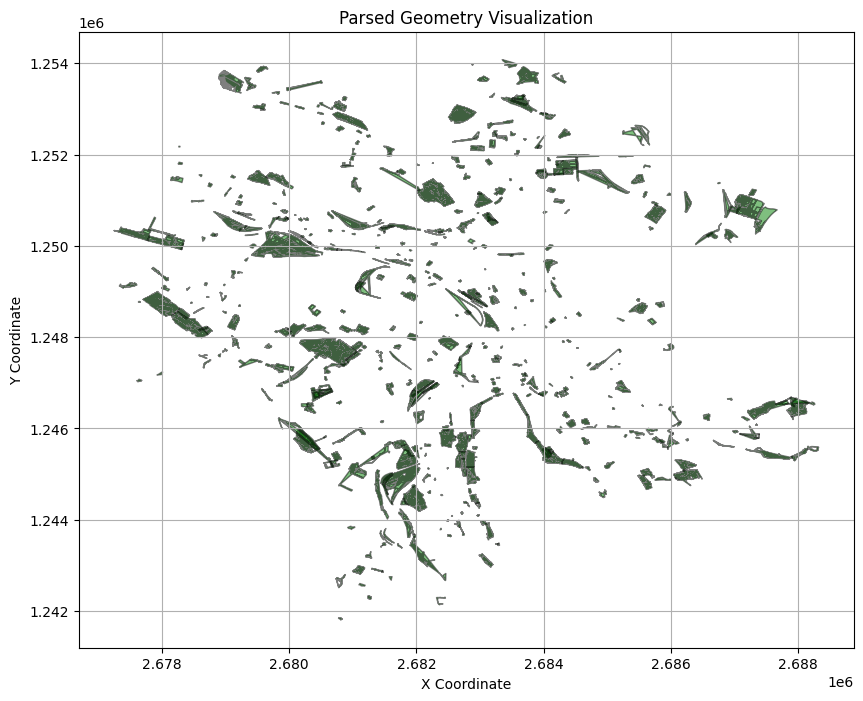

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
from geospatial import Polygon, Point  #class code

def plot_parsed_geometry_with_classes(df, geometry_column='parsed_geometry', title='Parsed Geometry Visualization'):
    fig, ax = plt.subplots(figsize=(10, 8))
    patches = []
    
    for _, row in df.iterrows():
        # Use the predefined Polygon class to handle the parsed_geometry
        polygon = Polygon(data=row[geometry_column], xcol=0, ycol=1)  # Create a Polygon object
        mpl_polygon = MplPolygon([(point.x, point.y) for point in polygon.points], closed=True, 
                                  edgecolor='black', facecolor='green', alpha=0.5)
        patches.append(mpl_polygon)
    
    # Add all polygons to the plot
    collection = PatchCollection(patches, match_original=True)
    ax.add_collection(collection)
    
    # Set plot limits and title
    ax.autoscale()
    ax.set_title(title)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()

# Call the function to visualize the data
plot_parsed_geometry_with_classes(dfParks_combined, geometry_column='parsed_geometry')

#### 2. LiDAR data preparation

#### 3. % Space Calculations (I think that we can make this an algorithm, too)

##### 3.1. Adding water bodies, converting to the same coordinate system as parks, making the same structure, calculating area, visualising.

In [ ]:
import pandas as pd
import ast
from pyproj import Transformer

# Load the water polygon CSV
csv_path = 'data/osm_water_polygons.csv'
water_df = pd.read_csv(csv_path)

# Change coordinates from WGS84 to CH1903+ / LV95
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2056", always_xy=True)

# Define function
def convert_geometry_to_ch1903(geometry_str):
    try:
        # Parse stringified list of dicts
        points = ast.literal_eval(geometry_str)

        # Convert (lon, lat) -> (x, y) in CH1903+
        swiss_coords = [transformer.transform(point['x'], point['y']) for point in points]

        return swiss_coords  # This becomes the 'parsed_geometry'
    except Exception as e:
        print("Error converting geometry:", e)
        return []

# Apply the function to convert and store as parsed_geometry
water_df['parsed_geometry'] = water_df['geometry'].apply(convert_geometry_to_ch1903)

# Check 
print(water_df[['parsed_geometry']].head())
print(f"Water bodies: {len(water_df)}")


                                     parsed_geometry
0  [(2682904.270281774, 1245020.54325581), (26829...
1  [(2684090.300598057, 1245500.3749201845), (268...
2  [(2666589.776121567, 1256693.3181668078), (266...
3  [(2681469.9122731695, 1243653.406871837), (268...
4  [(2685717.5970246308, 1248935.0668378877), (26...
Water bodies kept: 261


In [ ]:
# Define bounding box to filter water bodies only within area of our parks
xmin, xmax = 2.677e6, 2.689e6
ymin, ymax = 1.241e6, 1.255e6

# Function to check if a polygon intersects the bounding box
def is_within_bbox(coords, xmin, xmax, ymin, ymax):
    for x, y in coords:
        if xmin <= x <= xmax and ymin <= y <= ymax:
            return True  # at least one point is inside
    return False

# Apply the filter
water_df_filtered = water_df[water_df['parsed_geometry'].apply(lambda coords: is_within_bbox(coords, xmin, xmax, ymin, ymax))].reset_index(drop=True)

# Optional: verify result
print(water_df_filtered[['parsed_geometry']].head())
print(f"Water bodies kept: {len(water_df_filtered)}")

                                     parsed_geometry
0  [(2682904.270281774, 1245020.54325581), (26829...
1  [(2684090.300598057, 1245500.3749201845), (268...
2  [(2666589.776121567, 1256693.3181668078), (266...
3  [(2681469.9122731695, 1243653.406871837), (268...
4  [(2685717.5970246308, 1248935.0668378877), (26...
Water bodies kept: 260


In [ ]:
#Calculate area of each Water body
def calculate_polygon_area(polygon_points):
    n = len(polygon_points)
    if n < 3:
        return 0  # not a valid polygon

    area = 0
    for i in range(n):
        x1, y1 = polygon_points[i]
        x2, y2 = polygon_points[(i + 1) % n]  # wrap around
        area += x1 * y2 - x2 * y1

    return abs(area) / 2

# Apply to the DataFrame
def add_polygon_area_column(df):
    df['poly_area'] = df['parsed_geometry'].apply(calculate_polygon_area)
    return df

# Apply to your water_df
water_df_filtered = add_polygon_area_column(water_df_filtered)

# Optional: view result
print(water_df_filtered[['parsed_geometry', 'poly_area']].head())



                                     parsed_geometry     poly_area
0  [(2682904.270281774, 1245020.54325581), (26829...  8.797089e+07
1  [(2684090.300598057, 1245500.3749201845), (268...  8.119497e+02
2  [(2666589.776121567, 1256693.3181668078), (266...  1.725565e+06
3  [(2681469.9122731695, 1243653.406871837), (268...  9.064921e+04
4  [(2685717.5970246308, 1248935.0668378877), (26...  1.948262e+03


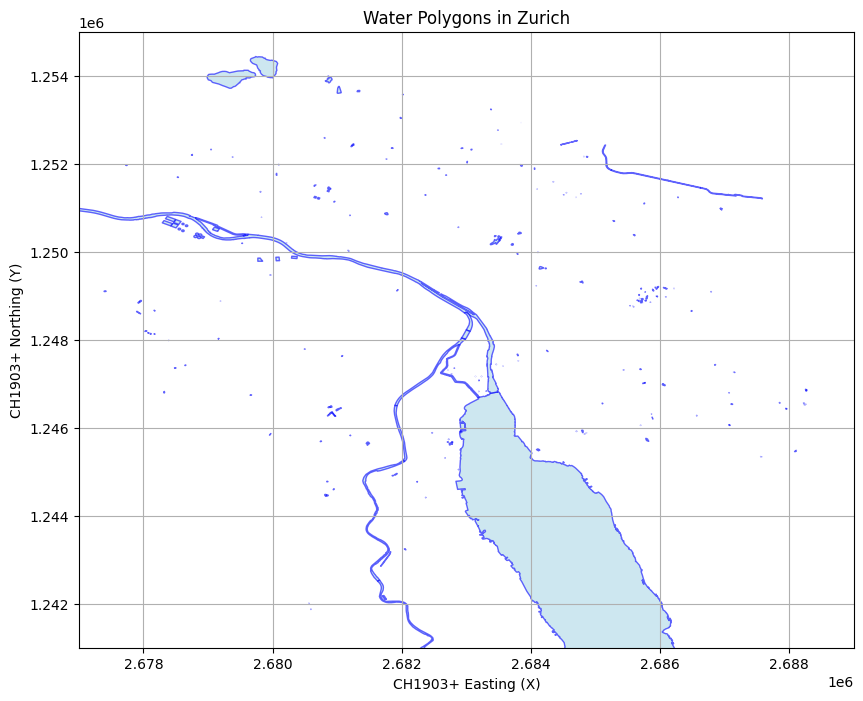

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
from geospatial import Polygon, Point  # your custom class

def plot_water_geometry(df, geometry_column='parsed_geometry', title='Water Polygons in Zurich'):
    fig, ax = plt.subplots(figsize=(10, 8))
    patches = []

    for _, row in df.iterrows():
        polygon = Polygon(data=row[geometry_column], xcol=0, ycol=1)
        mpl_polygon = MplPolygon([(point.x, point.y) for point in polygon.points], closed=True,
                                 edgecolor='blue', facecolor='lightblue', alpha=0.6)
        patches.append(mpl_polygon)

    collection = PatchCollection(patches, match_original=True)
    ax.add_collection(collection)

    # Set axis limits (CH1903+ / LV95)
    ax.set_xlim(2.677e6, 2.689e6)
    ax.set_ylim(1.241e6, 1.255e6)

    ax.set_title(title)
    ax.set_xlabel("CH1903+ Easting (X)")
    ax.set_ylabel("CH1903+ Northing (Y)")
    plt.grid(True)
    plt.show()

# Call the function
plot_water_geometry(water_df_filtered)


##### 3.2. Keep only water polygons that:

        - are inside park polygons (ponds),
        - intersect park polygons (at least one point inside) (rivers) - and cut them with park polygon
        - border park polygons (touching any edge) (Zurichhorn and Lake of Zurich).

##### 3.3. Calculate proportion of greenspace and blue space in parks

#### 4. Data Merging/Joining

#### 5. Point in Polygon (Algorithm)

### 6. Socialshilfe data prep

#### X. Clustering (We could attempt an algorithm)